In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('hanoi_quality.csv')
df1=df.reset_index()['pm25']

In [3]:
df1.shape

(1920,)

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
df1.shape

(1920, 1)

In [6]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [7]:
print(train_size)
print(test_size)

1536
384


In [8]:
print(train_data.shape)
print(test_data.shape)


(1536, 1)
(384, 1)


In [9]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [10]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)


(1435, 100)
(1435,)
(283, 100)
(283,)


In [12]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


In [13]:
print(X_train.shape)
print(X_test.shape)

(1435, 100, 1)
(283, 100, 1)


In [14]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 35s 525ms/step - loss: 0.0505 - val_loss: 0.0303
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 439ms/step - loss: 0.0216 - val_loss: 0.0307
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 394ms/step - loss: 0.0216 - val_loss: 0.0305
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 404ms/step - loss: 0.0222 - val_loss: 0.0299
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 454ms/step - loss: 0.0215 - val_loss: 0.0298
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 338ms/step - loss: 0.0211 - val_loss: 0.0294
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 273ms/step - loss: 0.0211 - val_loss: 0.0292
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 406ms/step - loss: 0.0208 - val_loss: 0.0307
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 461ms/step - loss: 0.0205 - val_loss: 0.0284
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 294ms/step - loss: 0.0192 - val_loss: 0.0287
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - loss: 0.0196 - val_loss: 0.0270
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━

In [16]:
X_test.shape

(283, 100, 1)

In [17]:
# 10. Dự báo dữ liệu test,
train_predict=model.predict(X_train)
y_pred=model.predict(test_data.reshape(test_data.shape[0],test_data.shape[1] , 1))


45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 245ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step


In [18]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)


In [19]:
test_data.shape

(384, 1)

In [20]:
y_pred.shape

(384, 1)

In [21]:
ytest=scaler.inverse_transform(test_data)
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Đánh giá độ chính xác thuật toán bằng MAPE
test_mape = np.mean(np.abs(ytest - y_pred)/np.abs(ytest))*100

print('Testing MAPE:', test_mape)

# Đánh giá độ chính xác thuật toán bằng MAE
test_mae = np.mean(abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 49.86043513200014
Testing MAPE: 55.707721158492795
Testing MAE: 45.35183566311995


In [22]:
x_input=test_data[60:].reshape(1,-1)
x_input.shape

(1, 324)

In [23]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=324
i=0
while(i<90):

    if(len(temp_input)>324):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


(1, 324)
[0.41327915]
325
1 day input [0.30697674 0.35813953 0.47906977 0.37209302 0.26976744 0.36744186
 0.33488372 0.21395349 0.14418605 0.18604651 0.17209302 0.24651163
 0.34418605 0.28837209 0.34883721 0.32093023 0.26976744 0.24651163
 0.30232558 0.26046512 0.19069767 0.23255814 0.19069767 0.22325581
 0.2372093  0.30697674 0.34418605 0.42790698 0.33023256 0.33953488
 0.24186047 0.26046512 0.3627907  0.39069767 0.28372093 0.41860465
 0.25581395 0.30232558 0.28372093 0.31627907 0.26511628 0.35813953
 0.22325581 0.32093023 0.2        0.27906977 0.2372093  0.4
 0.4744186  0.4744186  0.36744186 0.1627907  0.25581395 0.44651163
 0.41860465 0.26511628 0.31627907 0.44651163 0.40930233 0.42325581
 0.19069767 0.13488372 0.22790698 0.34883721 0.35348837 0.29302326
 0.22325581 0.13488372 0.15348837 0.15348837 0.1627907  0.26046512
 0.39069767 0.34883721 0.14883721 0.19069767 0.36744186 0.47906977
 0.31627907 0.34883721 0.41395349 0.40930233 0.32093023 0.30232558
 0.26976744 0.18139535 0.283720

In [24]:
print(x_input.shape)


(1, 324, 1)


In [25]:
print(test_data.shape)

(384, 1)


In [26]:
test_data.shape

(384, 1)

In [27]:
y_pred.shape

(384, 1)

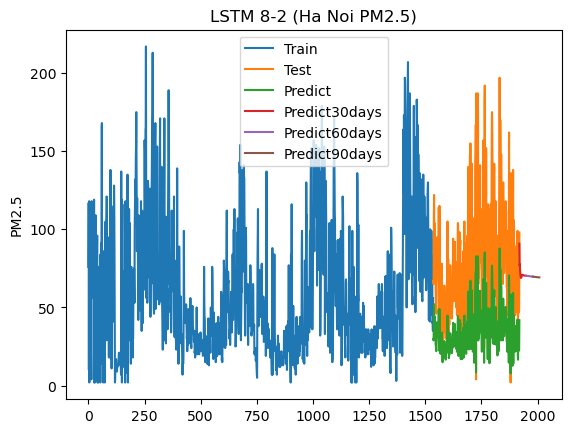

In [31]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))
plt.legend(['Train','Test','Predict','Predict30days', 'Predict60days', 'Predict90days'])
plt.title('LSTM 8-2 (Ha Noi PM2.5)')
plt.ylabel('PM2.5')
plt.show()

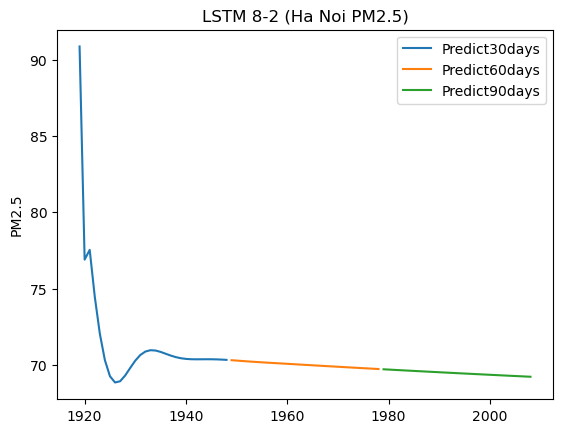

In [32]:
# 14.Vẽ hình
# Dự đoán 90 ngày tiếp theo

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))
plt.legend(['Predict30days', 'Predict60days', 'Predict90days'])
plt.title('LSTM 8-2 (Ha Noi PM2.5)')
plt.ylabel('PM2.5')
plt.show()

In [30]:
print(scaler.inverse_transform(lst_output))

[[90.85501638]
 [76.90319923]
 [77.53999573]
 [74.47660235]
 [72.04999906]
 [70.31630275]
 [69.26626098]
 [68.85958341]
 [68.93853661]
 [69.31613055]
 [69.81388432]
 [70.29123661]
 [70.66045594]
 [70.88585895]
 [70.97252679]
 [70.95060033]
 [70.86014566]
 [70.73974234]
 [70.61964017]
 [70.51908088]
 [70.44670817]
 [70.40269506]
 [70.38178739]
 [70.37616801]
 [70.37787241]
 [70.38031366]
 [70.37904498]
 [70.3718878 ]
 [70.35850254]
 [70.33983108]
 [70.3174625 ]
 [70.29312682]
 [70.26828495]
 [70.24400052]
 [70.22081178]
 [70.19891736]
 [70.17820191]
 [70.15837711]
 [70.13908413]
 [70.12003464]
 [70.10100436]
 [70.08183953]
 [70.06252092]
 [70.04304853]
 [70.02347362]
 [70.0038923 ]
 [69.98434302]
 [69.96487704]
 [69.94555843]
 [69.92636797]
 [69.9073377 ]
 [69.88842276]
 [69.86962956]
 [69.85092607]
 [69.83235073]
 [69.81385228]
 [69.79543072]
 [69.77706683]
 [69.75880545]
 [69.74063379]
 [69.7225326 ]
 [69.70453393]
 [69.68661857]
 [69.66880572]
 [69.65106976]
 [69.63343632]
 [69.61587